## Exercise 2:Analysis of Gasoline Prices

Name:Niharika Kumari

In [26]:
import pandas as pd
import numpy as np

# import bokeh 
from IPython.display import display, Markdown
from bokeh.plotting import figure, show, Figure
from bokeh.models import ColumnDataSource, Label
from bokeh.models import HoverTool
from bokeh.models.glyphs import Text
from bokeh.palettes import Spectral3
from bokeh.layouts import row, column, gridplot
import seaborn as sns
import matplotlib.pylab as plt

#from bokeh.io import output_file, show
from bokeh.models import GeoJSONDataSource
import bokeh.models as bmo

from bokeh.sampledata.sample_geojson import geojson
import bokeh.palettes as bp

# tell bokeh to show the figures in the notebook
from bokeh.io import output_notebook
output_notebook()
#latest
import pandas as pd
import missingno as msno
import warnings
warnings.filterwarnings('ignore')





Loading BokehJS ...

# Preprocessing of Data

We need to clean the station data as there are data missing

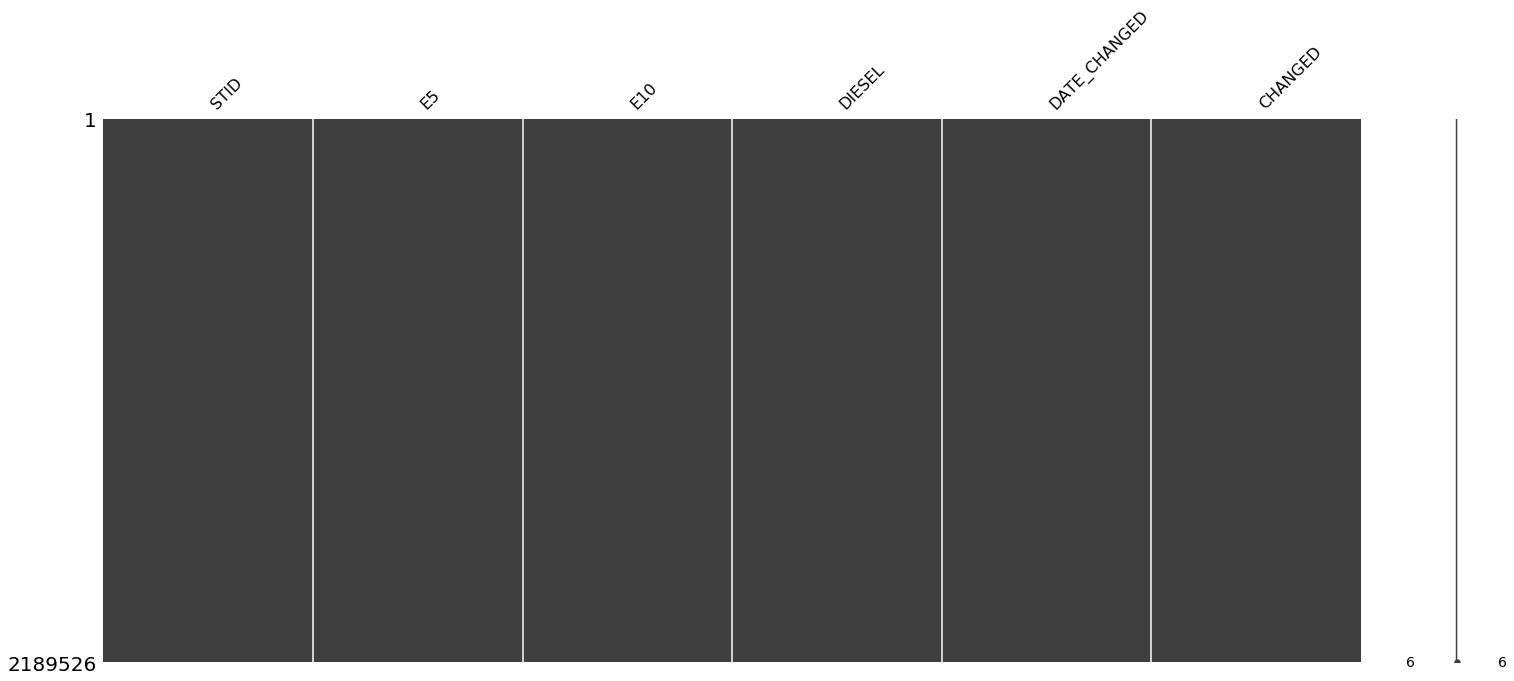

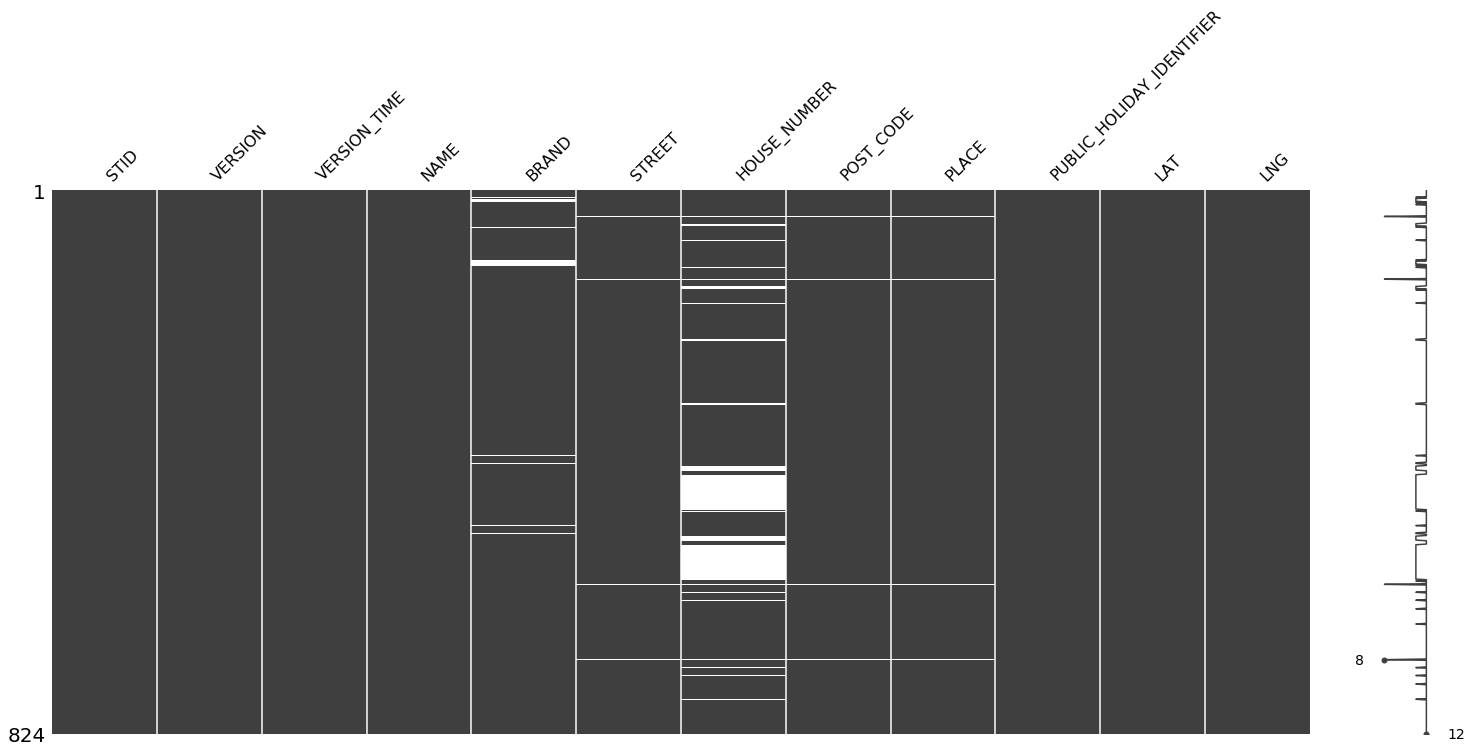

In [27]:
prices = pd.read_csv('example_sprit_cut_prices.csv', sep=';')
msno.matrix(prices)
#print(prices.head())

station = pd.read_csv('example_sprit_cut_station.csv', sep=';')
station.rename(columns={'ID':'STID'}, inplace=True)
msno.matrix(station)
#print(station.head())
#station.info()

# Data Cleaning:

In [28]:
import numpy as np
#remove all unimportant columns from station dataframe  
to_drop = ['HOUSE_NUMBER','PUBLIC_HOLIDAY_IDENTIFIER']
station.drop(to_drop, inplace=True, axis=1)
station.drop_duplicates(keep=False)
station.fillna(0, inplace=True)

    
#ms.matrix(station)
#station = station.replace('', np.nan, inplace=True)
station.fillna(value='UNKNOWN')

#removing non active brands
station = station[station['POST_CODE'] != 'nicht']
#station.loc[station['POST_CODE'] == 'nicht']
station.replace('\\N', 'UNKNOWN', inplace=True)
#station.replace(0, 'UNKNOWN', inplace=True)

station.loc[station['BRAND'] == 'UNKNOWN']
station['POST_CODE'] = station['POST_CODE'].replace('UNKNOWN', '0')
#print(station['POST_CODE'].unique())
station['VERSION_TIME']= pd.to_datetime(station['VERSION_TIME']) 
prices['DATE_CHANGED']= pd.to_datetime(prices['DATE_CHANGED']) 
station['LAT'] = station['LAT'].astype(float)
station['LNG'] = station['LNG'].astype(float)
station = station[station.BRAND != 0]
station = station[station.BRAND != 'UNKNOWN']
station.replace({'BRAND' : { '^Auto Zotz.*' : 'Auto Zotz', 
                                           '^Frei.*' : 'Freie Tankstelle',
                                           '^Raiffeisen.*' : 'Raiffeisen Tankstelle',
                                           '^Sb.*' : 'Sb Markt Tankstelle',
                                           '^Supermarkt.*' : 'Supermarkt Tankstelle'
                                            }},regex=True,inplace=True)

station.replace({'BRAND' : { '^Autohaus Holz.*' : 'Autohaus Holz', 
                                           '^Eberhardt.*' : 'Eberhardt',
                                           '^Globus Handelshof .*' : 'Globus Handelshof Gmbh & Co. Kg',
                                           '^Sbk .*' : 'Sbk - Tankstelle',
                                            }},regex=True,inplace=True)

station['BRAND'].str.upper()

station['BRAND'].unique()

array(['ARAL', 'JET', 'Supermarkt Tankstelle', 'Tankhof Iffezheim',
       'Schiffer & Nicklaus GmbH', 'Sefrin Heizöl & Kraftstoffe', 'bft',
       'Markant', 'AVIA', 'Bft', 'Freie Tankstelle',
       'AUTO ZOTZ Landau in der Pfalz   Tanken und waschen', 'HEM',
       'Fritz Walter GmbH', 'TAMOIL', 'rnt', 'Schuster & Sohn KG',
       'Raiffeisen Tankstelle', 'E Center', 'Eberhardt', 'BFT', 'Agip',
       'Winkler', 'Mr. Wash Autoservice AG', 'ESSO',
       'ZG Raiffeisen Energie', 'freie Tankstelle', 'CLASSIC', 'Shell',
       'Preis', 'mtb', 'Tankcenter', 'TS ARNT', 'frei', 'OMV',
       'Frühmesser GmbH', 'OIL!', 'SB Markt', 'SB', 'TOTAL', 'ED',
       'SB-Markttankstelle',
       'AUTO ZOTZ Herxheim b.LD.       Tanken an L.493', 'Total',
       'Markenfreie TS', 'TOP', 'T', 'ELAN', 'Tankstelle Heinz'],
      dtype=object)

In [29]:
def remove_invalid_prices(fuel_name):
    fuel_invalid=prices[prices[fuel_name]<=0]
    prices.drop(fuel_invalid.index,axis=0,inplace=True)

remove_invalid_prices('E5')
remove_invalid_prices('E10')
remove_invalid_prices('DIESEL')

In [30]:
def normalise_data(fuel_name):
    data_mean, data_std = prices[fuel_name].mean(), prices[fuel_name].std()
    # identify outliers upto 3 standard deviations
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off

    prices[fuel_name]=np.where(np.logical_or(prices[fuel_name] <
                                                lower,prices[fuel_name] > upper), 
                                  prices[fuel_name].median(), 
                                  prices[fuel_name])


normalise_data('E5')
normalise_data('E10')
normalise_data('DIESEL')


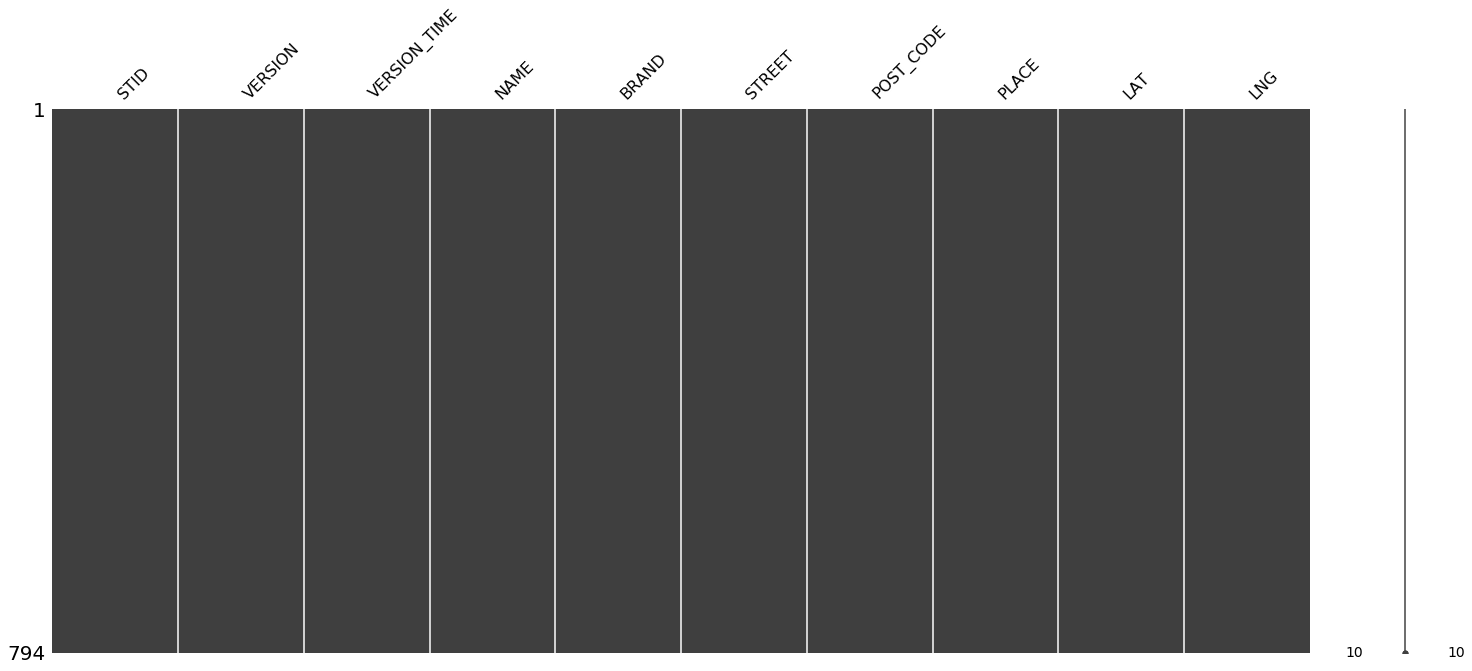

In [31]:
msno.matrix(station)

data is clean.

In [32]:
#visualisation
import datetime


prices['DATE_CHANGED'] = pd.to_datetime(prices['DATE_CHANGED'])

#station[['LAT', 'LNG','BRAND','NAME','VERSION_TIME']]
#station['DAYS'] = currentDT -station['VERSION_TIME']
#station[['LAT', 'LNG','BRAND','NAME','VERSION_TIME','DAYS']]

In [33]:

merged_df= pd.merge(station,prices, on='STID')
#print(merged_df.head())
no_of_stations = merged_df.STID.nunique()
no_of_brands = merged_df.BRAND.nunique()
print('No of unique stations are%d'%no_of_stations)
print('No of unique brands are%d'%no_of_brands)

# brand_existence = merged_df.groupby('BRAND')['DATE_CHANGED']
# brand_start=brand_existence.min().reset_index()
# brand_end=brand_existence.max().reset_index()
# # get brand history in days and 
# brand_history = (pd.to_datetime(brand_end['DATE_CHANGED'])-pd.to_datetime(brand_start['DATE_CHANGED'])).dt.days
# brand_end['No of Days'] = brand_history
history = merged_df.groupby(['STID']).DATE_CHANGED.agg([min,max]).reset_index()
history['history_days'] = history['max']-history['min']
history['history_days'] =history['history_days'] / np.timedelta64(1, 'D')
history = history.reset_index().sort_values('history_days', ascending=False)
top_100 = history['STID'][:3]
#top_3 = history['STID'][:3]
history.head(5)
#print(top_100)

No of unique stations are387
No of unique brands are49


,index,STID,min,max,history_days
7,7,033bce61-7584-45e7-94dd-952fd0b4899c,2014-06-08 09:50:01,2015-09-29 23:34:01,478.572222
88,88,446bb537-46ac-47b2-86e9-d8b8193f1285,2014-06-08 09:50:01,2015-09-29 23:34:01,478.572222
229,229,94179bf8-764e-4721-b261-62c7bd510995,2014-06-08 09:50:01,2015-09-29 23:34:01,478.572222
34,34,197a2371-2190-40c8-b899-67136a2cd51b,2014-06-08 09:50:01,2015-09-29 23:30:01,478.569444
85,85,41a91145-91f7-441b-8ff4-a46f5aff37cc,2014-06-08 09:50:01,2015-09-29 23:30:01,478.569444


In [34]:
def bar_chart(x,y,x_label,y_label):
    

    p = figure(x_range=x, plot_height=350,plot_width=800, 
           toolbar_location=None, tools="")

    p.vbar(x=x, top=y, width=0.3)
    p.xgrid.grid_line_color = None
    p.xaxis.axis_label = x_label
    p.yaxis.axis_label = y_label
    p.xaxis.major_label_orientation = 0.5
    p.y_range.start = 0

    show(p)

In [35]:
#history = history.drop(history.index[0])
#print(list(history['BRAND']))
#bar_chart(list(history['STID']),history['history_days'],'STID','days')

# Extract the top 100 gas stations with longest history

In [36]:
#extract the prices of only the top 100 stids
top100_prices = prices[prices['STID'].isin(top_100)]

top100_prices['HR'] = top100_prices['DATE_CHANGED'].map(
    lambda x: x.hour
)
top100_prices['date'] = top100_prices['DATE_CHANGED'].map(
    lambda x: x.date()
)
top100_prices.head()
top100_prices = top100_prices[top100_prices['HR'].isin([7,8,9,10,11,12,13,14,15,16,17,18,19,20])]

top100_prices.head(5)
#top100_prices.describe()


,STID,E5,E10,DIESEL,DATE_CHANGED,CHANGED,HR,date
153382,94179bf8-764e-4721-b261-62c7bd510995,1299.0,1259.0,1179.0,2014-12-16 16:46:01,21,16,2014-12-16
153383,94179bf8-764e-4721-b261-62c7bd510995,1289.0,1249.0,1139.0,2014-12-17 15:22:01,20,15,2014-12-17
153389,94179bf8-764e-4721-b261-62c7bd510995,1459.0,1419.0,1319.0,2014-11-06 09:13:00,20,9,2014-11-06
153390,94179bf8-764e-4721-b261-62c7bd510995,1489.0,1449.0,1299.0,2014-11-06 09:49:00,21,9,2014-11-06
153391,94179bf8-764e-4721-b261-62c7bd510995,1489.0,1449.0,1309.0,2014-11-07 09:41:00,21,9,2014-11-07


In [37]:
e5_data = top100_prices.copy()
e5_data = e5_data.drop(labels = ["E10",'DIESEL'],axis = 1) 

e10_data = top100_prices.copy()
e10_data = e10_data.drop(labels = ["E5",'DIESEL'],axis = 1) 

diesel_data = top100_prices.copy()
diesel_data = diesel_data.drop(labels = ["E5",'E10'],axis = 1) 

diesel = diesel_data.groupby(['STID','date']).DIESEL.agg(['mean']).reset_index()
e5 = e5_data.groupby(['STID','date']).E5.agg(['mean']).reset_index()
e10 = e10_data.groupby(['STID','date']).E10.agg(['mean']).reset_index()

e5.insert(0, 'index', range(0, 0 + len(e5)))
e10.insert(0, 'index', range(0, 0 + len(e10)))
diesel.insert(0, 'index', range(0, 0 + len(diesel)))
#print(diesel.head())

In [38]:
def line(x,y,x_label,y_label):
    
    p = figure(plot_width=600, plot_height=400)

    
    # add a line renderer
    p.xaxis.axis_label = x_label
    p.yaxis.axis_label = y_label
    p.line(x, y, line_width=2)

    show(p)

In [76]:
def rolling_average(train,test):
    train = np.array(train)
    test = test.values
    mean  = train.mean()
    loss = abs(mean - test)
    return loss,mean

In [40]:
e5_train, e5_test = np.split(e5, [int(.75*len(e5))])

In [41]:
print(len(e5_train))

1075


In [42]:
from statistics import mean 

In [43]:
def train(X,Y):
    count = 0
    window_dict = {} 
    for train_index, test_index in tscv.split(e5_train):

        train = e5_train.iloc[train_index]
        test = e5_train.iloc[test_index]

        #print(train_index, test_index)
        train_start, train_end = train.iloc[0,0], train.iloc[-1,0]
        test_start, test_end = test.iloc[0,0], test.iloc[-1,0]    
        loss = []
        for i in range(n-(len(train_index))):


            #print(train_start, train_end)
            #print(test_start)

            X_train, X_test = X[train_start:train_end+1], X[test_start:test_end+1]
            y_train, y_test = Y[train_start:train_end+1], Y[test_start:test_end+1]

            iloss,mean = rolling_average(y_train,y_test)
            #print('loss is',iloss)
            loss.append(iloss[0])

            train_start =train_start+1
            train_end = train_end+1

            test_start =test_start +1
            test_end = test_end +1


        #print(loss)
        average_loss = mean(loss) 
        #print(average_loss)
        window_dict[len(train_index)]  =  average_loss
        
    return window_dict  


In [77]:
#Take window size of 3 and do prediction on test set
def predict(window,df):
    n = len(df['date'])
    X = df['date']
    Y = df['mean']
    predicted_mean = []
    
    train_index = [i for i in range(window)]
    test_index = [window]
    
    train = df.iloc[train_index]
    test = df.iloc[test_index]
    
    #print(train_index, test_index)
    train_start, train_end = train.iloc[0,0], train.iloc[-1,0]
    test_start, test_end = test.iloc[0,0], test.iloc[-1,0]  
    #print(Y[train_start:train_end+1])
    
    loss = []
    for i in range(n-4):
        X_train, X_test = X[train_start:train_end+1], X[test_start:test_end+1]
        y_train, y_test = Y[train_start:train_end+1], Y[test_start:test_end+1]
        #print(y_train)

        iloss,mean = rolling_average(y_train,y_test)
        predicted_mean.append(mean)
        #print('loss is',iloss)
        loss.append(iloss)

        train_start =train_start+1
        train_end = train_end+1

        test_start =test_start +1
        test_end = test_end +1

    #print(loss)   
    #test_loss = mean(loss) 
    return loss,predicted_mean


# Creating Model for prediction and training

Find the optimal window size

In [45]:
from sklearn.model_selection import TimeSeriesSplit

#use timeseries split to spit data
n = len(e5_train['date'])

X = e5_train['date']
Y = e5_train['mean']

tscv = TimeSeriesSplit(max_train_size=None, n_splits=n-1)
window_dict = train(X,Y)

x = list(window_dict.keys())
y = list(window_dict.values())
line([*window_dict],y,'window_size','loss')
print('We found optimal size of window to be 3') 



In [79]:

e5_test.index = np.arange(0, len(e5_test))
e5_test['index'] = np.arange(0, len(e5_test))
#print(e5_test.head())
loss,predicted_mean = predict(3,e5_test)

x = np.array(loss).tolist()
mean_loss = mean([i[0] for i in x])

print('average loss for the test set is:', mean_loss)    
#print(len(predicted_mean),len(e5_test))

average loss for the test set is: 14.366273736696272
355 359


probability distribution curve for loss 

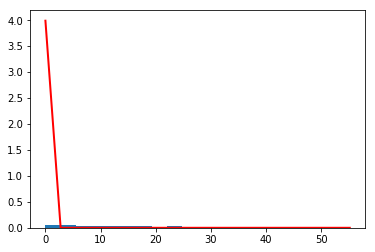

In [91]:
#pdc for loss
mu, sigma = 0, 0.1
count, bins, ignored = plt.hist([i[0] for i in x], 20, normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),linewidth=2, color='r')
plt.show()

# plot line chart to show the variation between predicted and actual mean

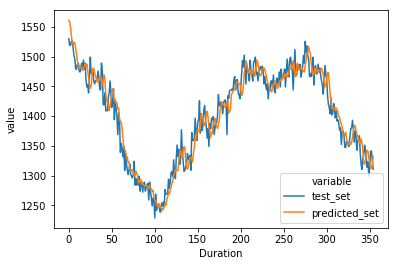

In [88]:
import seaborn as sns
# print(len(predicted_mean))
# print(len())  
data_preproc = pd.DataFrame({
    'Duration': range(len(predicted_mean)), 
    'test_set': e5_test['mean'][4:],
    'predicted_set': predicted_mean,
    })
sns.lineplot(x='Duration', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['Duration']))

In [ ]:
Window size 3 gave good predictions.

# Future prediction based on model